## Load data and perform cleaning and tabulation

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import pylab
import numpy as np
import sklearn
from sklearn import linear_model
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from statsmodels.stats import proportion

import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import balanced_accuracy_score, roc_auc_score,accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
param_alpha = 0.9
MAX_ALPHA = 1.0

# A_score_data_type
# dataType ="unmitigated" 
# dataType = "threshold_opt"
dataType ="Exponentiated_grad"

from fairlearn.reductions import ExponentiatedGradient,EqualizedOdds,DemographicParity

# constraint = "equalized_odds"
# const = EqualizedOdds()
constraint = "demographic_parity"
const = DemographicParity()


# sensitive_feature = "Sex"
sensitive_feature = "Race"

In [3]:
# Source: https://www.valentinmihov.com/2015/04/17/adult-income-data-set/

features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"] 

# Change these to local file if available
train_data = 'adult.data'
test_data = 'adult.test'

# This will download 3.8M
original_train = pd.read_csv(train_data, names=features, sep=r'\s*,\s*', 
                             engine='python', na_values="?")
# original_train = original_train.drop(columns=[drop],axis=1)

# This will download 1.9M
original_test = pd.read_csv(test_data, names=features, sep=r'\s*,\s*', 
                            engine='python', na_values="?", skiprows=1)
# original_test = original_test.drop(columns=[drop],axis=1)

num_train = len(original_train)
original = pd.concat([original_train, original_test])
roc_original = original
labels = original['Target']
labels = labels.replace('<=50K', 0).replace('>50K', 1)
labels = labels.replace('<=50K.', 0).replace('>50K.', 1)

# # peak into the original_train and original_test data
# print(original_train.head())
# print("**************************")
# print(original_test.head())

In [4]:
np.unique(original_test["Race"])

array(['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other',
       'White'], dtype=object)

In [5]:
## extract sensitive features
if sensitive_feature == "Sex":
    A = original_test["Sex"]
    # A_str_test = A.map({ 0:"Female", 1:"Male"})
    A_str_test = pd.get_dummies(A,drop_first=True)
    A_ = original_train["Sex"]
    A_str_train = pd.get_dummies(A_,drop_first=True)
if sensitive_feature == "Race":
    A = original_test["Race"]
    # A_str_test = A.map({ 0:"Female", 1:"Male"})
    A_str_test = A.apply(lambda row: 1 if row == 'White' else 0)
    A_ = original_train["Race"]
    A_str_train = A_.apply(lambda row: 1 if row == 'White' else 0)

In [6]:
import scipy.stats as ss
# Redundant column
del original["Education"]

# Remove target variable
del original["Target"]

In [7]:
def data_transform(df):
    """Normalize features."""
    binary_data = pd.get_dummies(df)
    feature_cols = binary_data[binary_data.columns[:-2]]
    scaler = preprocessing.StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(feature_cols), columns=feature_cols.columns)
    return data


## cleaning the total data which is original_train and original_test concatenated
data = data_transform(original)

## create separate train and test data w/ labels
train_data = data[:num_train]
train_labels = labels[:num_train]
test_data = data[num_train:]
test_labels = labels[num_train:]



# ############################################################

## Valid features remaining to meddle with:

    protected & cant drop: "Age",  "Race", "Sex"
    valid_features = [ "Workclass", "fnlwgt" "Education-Num", "Marital Status",
        "Occupation", "Relationship", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"] 

## LIGHTGBM Model for analysis


In [8]:
# Models
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

lgb_params = {
    'objective' : 'binary',
    'metric' : 'cross_entropy', 
    'learning_rate': 0.1,
    'num_leaves' : 10,
    'max_depth' : 3
}

model = lgb.LGBMClassifier(**lgb_params)

In [9]:
model.fit(train_data, train_labels)
# Scores on test set
test_scores = model.predict_proba(test_data)[:, 1]
test_pred = model.predict(test_data)

In [10]:
# Train AUC
roc_auc_score(train_labels, model.predict_proba(train_data)[:, 1])
# ACCURACY
accuracy_score(test_labels, test_pred)
# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(train_labels)) * 1

Plot feature importance to visualize which features are most useful for prediction

In [11]:
# # LightGBM feature importance 
# lgb.plot_importance(model, figsize = (10,20), height=0.3, title="Features importance (LightGBM)", importance_type="gain", max_num_features=100) 
# plt.show()

In [12]:
# Data processing
from sklearn.model_selection import train_test_split

# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds

# Metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    false_positive_rate, false_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference,
    equalized_odds_difference, count)


In [13]:
# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
#         "Demographic parity ratio": (
#             lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
#         "------": (lambda x: "", True),
#         "Overall balanced error rate": (
#             lambda x: 1-balanced_accuracy_score(y_true, x), True),
#         "Balanced error rate difference": (
#             lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
#         " ------": (lambda x: "", True),
        "False positive rate difference": (
            lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
#         "  ------": (lambda x: "", True),
#         "Overall AUC": (
#             lambda x: roc_auc_score(y_true, x), False),
        "Accuracy": (
             lambda x: accuracy_score(y_true, x), True),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

In [14]:
if dataType =="unmitigated" or dataType =="threshold_opt":
    postprocess_est = ThresholdOptimizer(
        estimator = model,
        constraints = constraint,
        prefit=True)

    balanced_idx1 = train_data[train_labels==1].index
    pp_train_idx = balanced_idx1.union(train_labels[train_labels==0].sample(n=balanced_idx1.size, random_state=124).index)
    df_train_balanced = train_data.loc[pp_train_idx, :]
    Y_train_balanced = train_labels.loc[pp_train_idx]
    A_train_balanced = A_.loc[pp_train_idx]


    postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

    postprocess_preds = postprocess_est.predict(test_data, sensitive_features= A)
    
    if constraint == "equalized_odds":
        models_dict = {"EO_Unmit:allFeat": (test_preds, test_scores),
                   "EO_ThOpt:allFeat": (postprocess_preds, postprocess_preds)}
    if constraint == "demographic_parity":
        models_dict = {"DP_Unmit:allFeat": (test_preds, test_scores),
                   "DP_ThOpt:allFeat": (postprocess_preds, postprocess_preds)}

if dataType == "Exponentiated_grad":
    from fairlearn.reductions import ExponentiatedGradient,EqualizedOdds,DemographicParity
    from xgboost import XGBClassifier
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=10)
    xgc = XGBClassifier(verbosity=0)
    eg = ExponentiatedGradient(estimator= model, constraints = const ,max_iter=2)
    eg.fit(train_data,train_labels, sensitive_features=A_)
    eg_test_preds = eg.predict(test_data)
    
    if constraint == "equalized_odds":
        models_dict = {"EO_Unmit:allFeat": (test_preds, test_scores),
                  "EO_ExGrd:allFeat": (eg_test_preds,eg_test_preds)}
    if constraint == "demographic_parity":
        models_dict = {"DP_Unmit:allFeat": (test_preds, test_scores),
                  "DP_ExGrd:allFeat": (eg_test_preds,eg_test_preds)}    

table_init = get_metrics_df(models_dict, test_labels, A_str_test)

In [15]:
table_init 

,DP_Unmit:allFeat,DP_ExGrd:allFeat
Overall selection rate,0.358885,0.178245
Demographic parity difference,0.147489,0.076096
False positive rate difference,0.092330,0.018567
False negative rate difference,0.030139,0.040264
Equalized odds difference,0.092330,0.040264
Accuracy,0.817272,0.869541
AUC difference,0.018585,0.010848


In [16]:
from ipynb.fs.full.ADULT_DATA_FUNCTIONS import create_table
from ipynb.fs.full.ADULT_DATA_FUNCTIONS import import_predef_funcs

valid_features = ["Workclass", "fnlwgt", "Education-Num", "Marital Status",
                  "Occupation", "Relationship", "Capital Gain", "Capital Loss",
                  "Hours per week", "Country","Sex","Age","Race"]
    

constraint = constraint
# table = pd.DataFrame() # already declared before for all features
table = table_init
for dr_feat in valid_features:
#     drop_val_f = valid_features
#     drop_val_f.remove(dr_feat) # drop one feature at a time from full list
    tempo = create_table(valid_features,train_data,train_labels,test_data,test_labels,
                  model,A,A_,A_str_train,A_str_test,
                  constraint,dr_feat,dataType)
#     print(tempo)
#     table = pd.concat(table,tempo)
    table = pd.concat([table, tempo], axis=1)
    
    
    

In [17]:
table 

,DP_Unmit:allFeat,DP_ExGrd:allFeat,DP_Unmit:WrkCls,DP_ExGrd:WrkCls,DP_Unmit:fnlwgt,DP_ExGrd:fnlwgt,DP_Unmit:EdNum,DP_ExGrd:EdNum,DP_Unmit:MarSts,DP_ExGrd:MarSts,...,DP_Unmit:HrPWk,DP_ExGrd:HrPWk,DP_Unmit:Cntry,DP_ExGrd:Cntry,DP_Unmit:Sex,DP_ExGrd:Sex,DP_Unmit:Age,DP_ExGrd:Age,DP_Unmit:Race,DP_ExGrd:Race
Overall selection rate,0.358885,0.178245,0.358148,0.176832,0.357902,0.178245,0.378232,0.166390,0.357349,0.173638,...,0.360052,0.177323,0.359315,0.178183,0.359069,0.177630,0.375468,0.172840,0.358393,0.167680
Demographic parity difference,0.147489,0.076096,0.149628,0.080946,0.146842,0.077596,0.151077,0.073756,0.147696,0.079218,...,0.146352,0.076520,0.149491,0.076524,0.146704,0.073879,0.165350,0.072286,0.139916,0.066263
False positive rate difference,0.092330,0.018567,0.095102,0.023566,0.091155,0.022050,0.096642,0.021803,0.093750,0.021803,...,0.093082,0.020439,0.093696,0.019742,0.091633,0.017611,0.111569,0.017420,0.084927,0.013553
False negative rate difference,0.030139,0.040264,0.027903,0.048579,0.033465,0.032641,0.044240,0.033515,0.027217,0.048752,...,0.023032,0.037056,0.036044,0.038259,0.028190,0.030978,0.053527,0.033965,0.022229,0.018892
Equalized odds difference,0.092330,0.040264,0.095102,0.048579,0.091155,0.032641,0.096642,0.033515,0.093750,0.048752,...,0.093082,0.037056,0.093696,0.038259,0.091633,0.030978,0.111569,0.033965,0.084927,0.018892
Accuracy,0.817272,0.869541,0.818377,0.867883,0.817026,0.868927,0.798661,0.861249,0.816228,0.868497,...,0.814385,0.867760,0.816719,0.868743,0.817579,0.870155,0.801425,0.865610,0.817026,0.866961
AUC difference,0.018585,0.010848,0.020216,0.012506,0.020701,0.005295,0.020431,0.005856,0.020390,0.013475,...,0.018366,0.008309,0.019609,0.009258,0.019566,0.006683,0.019583,0.008273,0.019386,0.002670


In [18]:
from ipynb.fs.full.ADULT_DATA_FUNCTIONS import compute_Ascore

abbr_feat = {"Age":"Age","Race":"Race","Sex":"Sex","Workclass":"WrkCls","fnlwgt":"fnlwgt","Education-Num":"EdNum","Marital Status":"MarSts",
                 "Occupation":"Occpn","Relationship":"Rltshp","Capital Gain":"CapGn","Capital Loss":"CapLs",
                 "Hours per week":"HrPWk","Country":"Cntry"}
    
flip_abbr = dict([(value, key) for key, value in abbr_feat.items()])

alpha = np.linspace(0,MAX_ALPHA,num=20)
checker = alpha[alpha>=param_alpha]
checker = checker[0]

Ascores, Ascore_df = compute_Ascore(table,alpha,constraint,dataType)
checker = Ascore_df.index[Ascore_df.index>=param_alpha]
checker = checker[0]
checker_idx = np.where(Ascore_df.index == checker)[0][0]

A_sc_dict = dict(zip(Ascore_df.columns,Ascore_df.iloc[checker_idx,:]))
info_dict = {}
info_dict[str(1)] = A_sc_dict
counter = 2;
k = 0
checker = valid_features
storage = []
flag = False
while np.any(Ascore_df.iloc[checker_idx,:] < 0):
        
    mx_feat = np.argmin(Ascore_df.iloc[checker_idx,:])
#     print(Ascore_df.columns[mx_feat])
    dummy = Ascore_df.columns[mx_feat]
    print(dummy)
    storage.append(dummy)
    
    if k == 0:
           
        dummy = dummy[9:]
        dummy = flip_abbr[dummy]
        valid_features.remove(dummy)
        
    else:


        dummy = dummy[9:]
        dummy = flip_abbr[dummy]
        valid_features.remove(dummy)
    
#   constraint = 'equalized_odds'
    # table = pd.DataFrame() # already declared before for all features
    table_new = create_table(valid_features,train_data,train_labels,test_data,test_labels,
                      model,A,A_,A_str_train,A_str_test,
                      constraint,None,dataType)
    for dr_feat in valid_features:
        tempo = create_table(valid_features,train_data,train_labels,test_data,test_labels,
                      model,A,A_,A_str_train,A_str_test,
                      constraint,dr_feat,dataType)
        
        table_new = pd.concat([table_new, tempo], axis=1)
    
    print(table_new.columns) 
    alpha = np.linspace(0,MAX_ALPHA,num=20)
    checker = alpha[alpha>=param_alpha]
    checker = checker[0]

    Ascores, Ascore_df = compute_Ascore(table_new,alpha,constraint,dataType)
    checker = Ascore_df.index[Ascore_df.index>=param_alpha]
#     checker = checker[0]
#     checker_idx = np.where(Ascore_df.index == checker)[0][0]

    info_dict[str(counter)] = dict(zip(Ascore_df.columns,Ascore_df.iloc[checker_idx,:]))
    counter = counter+1
    k = k+1
    
#     print(table_new.iloc[5,np.arange(0,table_new.shape[1]-1,2)])
            
    

DP_ExGrd:Race
Index(['DP_Unmit:allFeat', 'DP_ExGrd:allFeat', 'DP_Unmit:WrkCls',
       'DP_ExGrd:WrkCls', 'DP_Unmit:fnlwgt', 'DP_ExGrd:fnlwgt',
       'DP_Unmit:EdNum', 'DP_ExGrd:EdNum', 'DP_Unmit:MarSts',
       'DP_ExGrd:MarSts', 'DP_Unmit:Occpn', 'DP_ExGrd:Occpn',
       'DP_Unmit:Rltshp', 'DP_ExGrd:Rltshp', 'DP_Unmit:CapGn',
       'DP_ExGrd:CapGn', 'DP_Unmit:CapLs', 'DP_ExGrd:CapLs', 'DP_Unmit:HrPWk',
       'DP_ExGrd:HrPWk', 'DP_Unmit:Cntry', 'DP_ExGrd:Cntry', 'DP_Unmit:Sex',
       'DP_ExGrd:Sex', 'DP_Unmit:Age', 'DP_ExGrd:Age'],
      dtype='object')
DP_ExGrd:Occpn
Index(['DP_Unmit:allFeat', 'DP_ExGrd:allFeat', 'DP_Unmit:WrkCls',
       'DP_ExGrd:WrkCls', 'DP_Unmit:fnlwgt', 'DP_ExGrd:fnlwgt',
       'DP_Unmit:EdNum', 'DP_ExGrd:EdNum', 'DP_Unmit:MarSts',
       'DP_ExGrd:MarSts', 'DP_Unmit:Rltshp', 'DP_ExGrd:Rltshp',
       'DP_Unmit:CapGn', 'DP_ExGrd:CapGn', 'DP_Unmit:CapLs', 'DP_ExGrd:CapLs',
       'DP_Unmit:HrPWk', 'DP_ExGrd:HrPWk', 'DP_Unmit:Cntry', 'DP_ExGrd:Cntry',
      

In [19]:
import pprint as pp
pp.pprint(info_dict)

{'1': {'DP_ExGrd:Age': -0.047197660347557804,
       'DP_ExGrd:CapGn': 0.07278832718343337,
       'DP_ExGrd:CapLs': 0.02458533006609234,
       'DP_ExGrd:Cntry': 0.005380079443077151,
       'DP_ExGrd:EdNum': -0.02862736803928232,
       'DP_ExGrd:HrPWk': 0.005390626580603663,
       'DP_ExGrd:MarSts': 0.03892617068051695,
       'DP_ExGrd:Occpn': -0.04442384117234833,
       'DP_ExGrd:Race': -0.12226649264873823,
       'DP_ExGrd:Rltshp': 0.004333738596151937,
       'DP_ExGrd:Sex': -0.027637562392077434,
       'DP_ExGrd:WrkCls': 0.06048608945819362,
       'DP_ExGrd:fnlwgt': 0.018710533493778495},
 '2': {'DP_ExGrd:Age': 0.010532179099007048,
       'DP_ExGrd:CapGn': 0.11044977618834045,
       'DP_ExGrd:CapLs': 0.11461775394962607,
       'DP_ExGrd:Cntry': -0.005160463162789485,
       'DP_ExGrd:EdNum': 0.11105847941248427,
       'DP_ExGrd:HrPWk': 0.07854940758925891,
       'DP_ExGrd:MarSts': 0.05542779902717473,
       'DP_ExGrd:Occpn': -0.010309539735918017,
       'DP_ExGrd:Rl

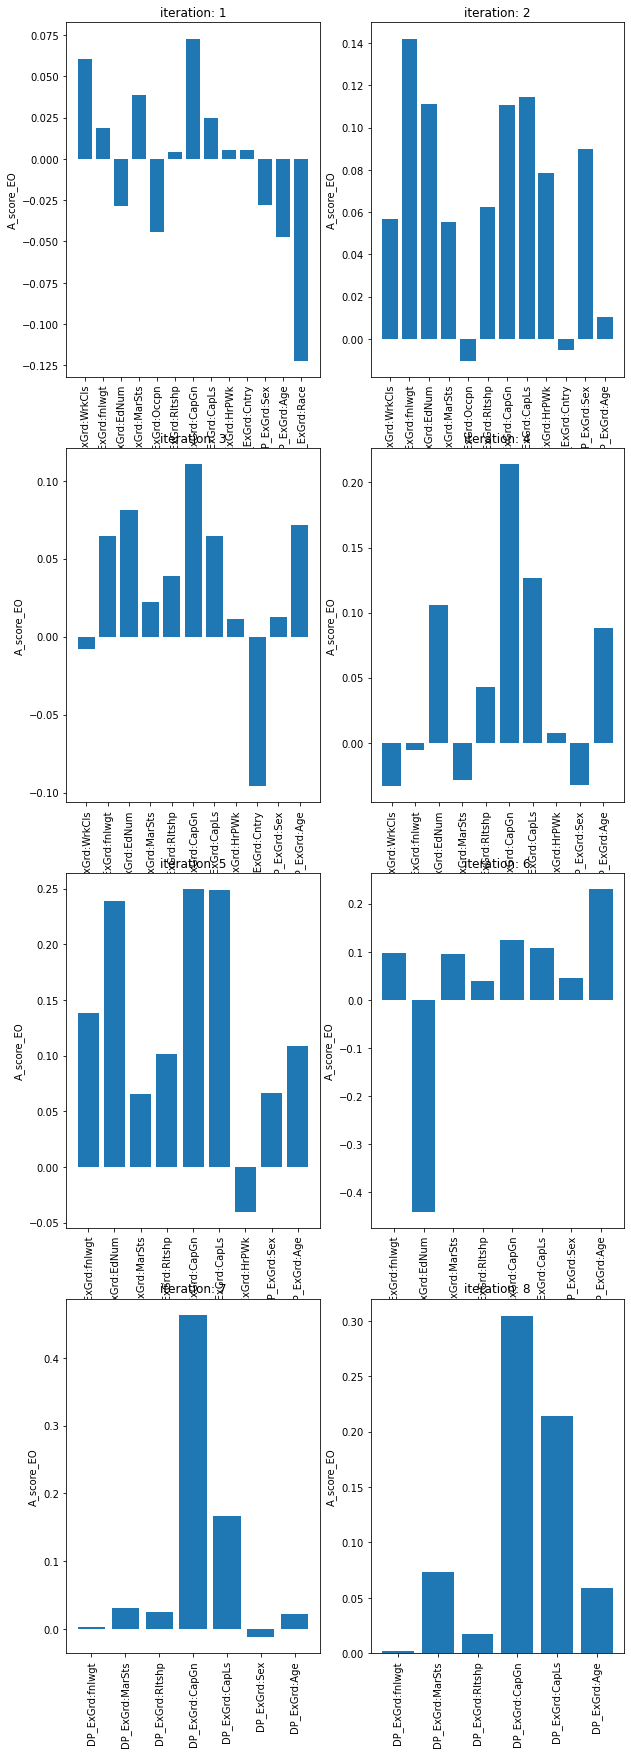

In [20]:
outer_key = info_dict.keys()
outer_val = list(info_dict.values())

plt.figure(figsize=(10,30))
for i in range(0,len(outer_val)):
    inner_keys = outer_val[i].keys()
    inner_vals = outer_val[i].values()
    plt.subplot(round(len(outer_val)/2),2,i+1)
    plt.title('iteration: '+str(i+1))
    plt.ylabel('A_score_EO')
    plt.bar(inner_keys, inner_vals)
    plt.xticks(rotation = 90);

In [21]:
print("******************************")
# dataType ="unmitigated" 
# dataType ="threshold_opt"
# dataType ="Exponentiated_grad" 
if dataType == "unmitigated":
    print("AUC vals (Unmitigated data in Ascore framework)")
    print()
    print(table_new.iloc[5,np.arange(0,table_new.shape[1]-1,2)])
if dataType == "threshold_opt":
    print("AUC vals (Threshold Opt data in framework)")
    print()
    print(table_new.iloc[5,np.arange(1,table_new.shape[1]+1,2)])
if dataType == "Exponentiated_grad":
    print("AUC vals (Exponentiated Grd data in framework)")
    print()
    print(table_new.iloc[5,np.arange(1,table_new.shape[1]+1,2)])
print("******************************")

******************************
AUC vals (Exponentiated Grd data in framework)

DP_ExGrd:allFeat    0.830846
DP_ExGrd:fnlwgt     0.831153
DP_ExGrd:MarSts     0.830784
DP_ExGrd:Rltshp     0.831644
DP_ExGrd:CapGn      0.792887
DP_ExGrd:CapLs      0.814815
DP_ExGrd:Age        0.831399
Name: Accuracy, dtype: float64
******************************


In [22]:
print("******************************")
# dataType ="unmitigated" 
# dataType ="threshold_opt"
# dataType ="Exponentiated_grad" 

if constraint == "equalized_odds":
    if dataType == "unmitigated" :
        print("Eq. Odds vals (Unmitigated data in Ascore framework)")
        print()
        print(table_new.iloc[4,np.arange(0,table_new.shape[1]-1,2)])
    if dataType == "threshold_opt":
        print("Eq. Odds vals (Threshold Opt data in framework)")
        print()
        print(table_new.iloc[4,np.arange(1,table_new.shape[1]+1,2)])
    if dataType == "Exponentiated_grad" :
        print("Eq. Odds vals (Exponentiated Grd data in framework)")
        print()
        print(table_new.iloc[4,np.arange(1,table_new.shape[1]+1,2)])
    print("******************************")
    
if constraint == "demographic_parity":
    if dataType == "unmitigated" :
        print("DP vals (Unmitigated data in Ascore framework)")
        print()
        print(table_new.iloc[1,np.arange(0,table_new.shape[1]-1,2)])
    if dataType == "threshold_opt":
        print("DP vals (Threshold Opt data in framework)")
        print()
        print(table_new.iloc[1,np.arange(1,table_new.shape[1]+1,2)])
    if dataType == "Exponentiated_grad" :
        print("DP vals (Exponentiated Grd data in framework)")
        print()
        print(table_new.iloc[1,np.arange(1,table_new.shape[1]+1,2)])
    print("******************************") 



******************************
DP vals (Exponentiated Grd data in framework)

DP_ExGrd:allFeat    0.027538
DP_ExGrd:fnlwgt     0.027610
DP_ExGrd:MarSts     0.029683
DP_ExGrd:Rltshp     0.028040
DP_ExGrd:CapGn      0.036325
DP_ExGrd:CapLs      0.033721
DP_ExGrd:Age        0.029257
Name: Demographic parity difference, dtype: float64
******************************


In [23]:
outer_val = list(info_dict.values())
print(outer_val[0].keys())

dict_keys(['DP_ExGrd:WrkCls', 'DP_ExGrd:fnlwgt', 'DP_ExGrd:EdNum', 'DP_ExGrd:MarSts', 'DP_ExGrd:Occpn', 'DP_ExGrd:Rltshp', 'DP_ExGrd:CapGn', 'DP_ExGrd:CapLs', 'DP_ExGrd:HrPWk', 'DP_ExGrd:Cntry', 'DP_ExGrd:Sex', 'DP_ExGrd:Age', 'DP_ExGrd:Race'])


### trying random things

In [24]:
Ascore_df.index
checker = Ascore_df.index[Ascore_df.index>=0.2]
checker = checker[0]
checker_idx = np.where(Ascore_df.index == checker)[0][0]

In [25]:
dummy = "EO_Unmit:Age"

In [26]:
dummy[0:2]+"_ThrOpt:"+dummy[9:]

'EO_ThrOpt:Age'

In [27]:
checker = valid_features

In [28]:
np.all(checker == valid_features)

True